In [42]:
import numpy as np
import keras 
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as k
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, ImageEnhance
from pathlib import Path
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
y_train_orig = y_train
y_test_orig = y_test
img_rows, img_cols = 28, 28


In [5]:

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [6]:

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [ ]:
# Improved model architecture
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout1 = Dropout(0.25)(pool2)
flatten = Flatten()(dropout1)
dense1 = Dense(128, activation='relu')(flatten)
dropout2 = Dropout(0.5)(dense1)
output = Dense( activation='softmax')(dropout2)
10,

In [8]:
# Create and compile model
model = Model([input_layer], output)
model.compile(optimizer=keras.optimizers.Adam(),  # Changed to Adam optimizer
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,570 (1.75 MB)

 Trainable params: 458,570 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training with validation split and callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2
)

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 191s 110ms/step - accuracy: 0.8558 - loss: 0.4442 - val_accuracy: 0.9862 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 202s 110ms/step - accuracy: 0.9748 - loss: 0.0847 - val_accuracy: 0.9900 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 203s 110ms/step - accuracy: 0.9821 - loss: 0.0612 - val_accuracy: 0.9915 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 188s 111ms/step - accuracy: 0.9846 - loss: 0.0500 - val_accuracy: 0.9922 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 188s 111ms/step - accuracy: 0.9880 - loss: 0.0401 - val_accuracy: 0.9930 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 202s 111ms/step - accuracy: 0.9885 - loss: 0.0369 - val_accuracy: 0.9927 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 377s 224ms

In [10]:
# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0172
Test accuracy: 0.9953


In [11]:
# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [12]:

total_samples = x_train.shape[0]
training_samples = int(total_samples * 0.9)
validation_samples = total_samples - training_samples

print("Total dataset size:", total_samples)
print("Training dataset size:", training_samples)
print("Validation dataset size:", validation_samples)

Total dataset size: 60000
Training dataset size: 54000
Validation dataset size: 6000


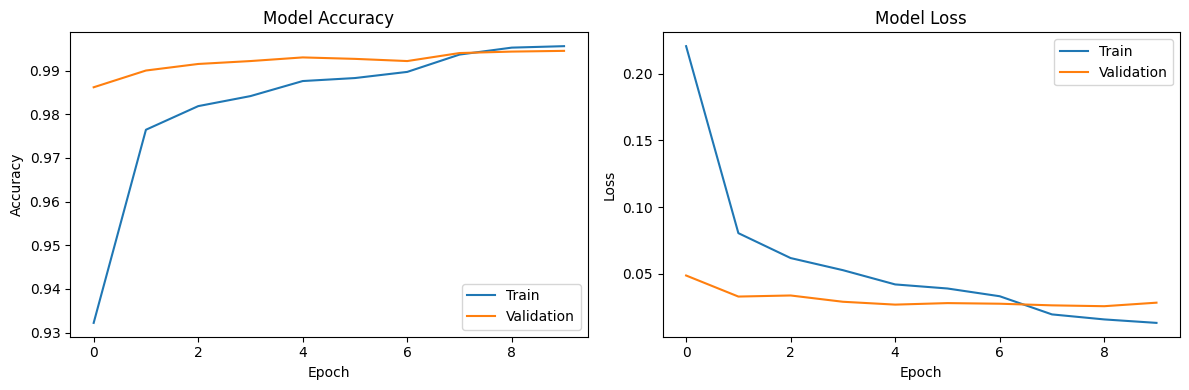

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

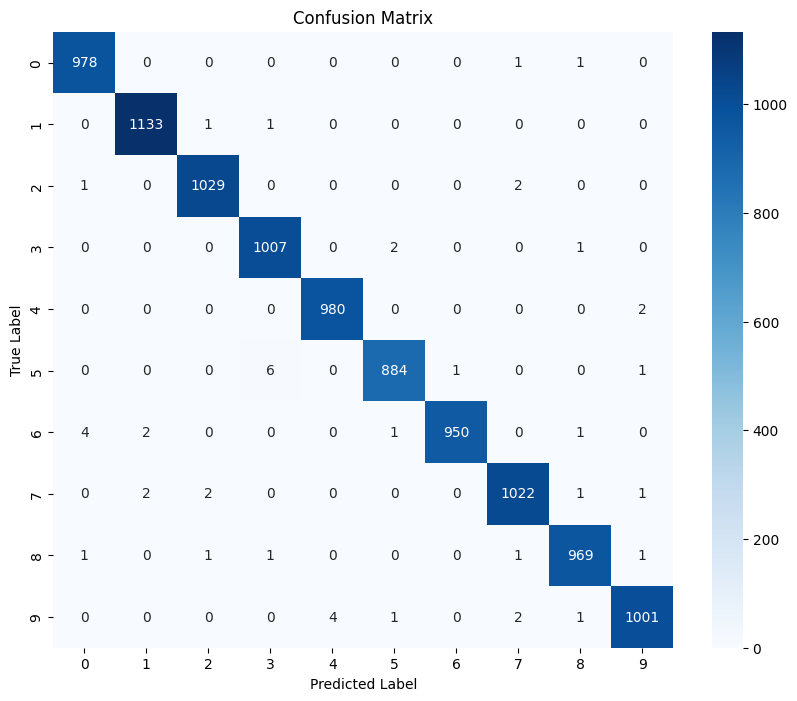

In [14]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_orig, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

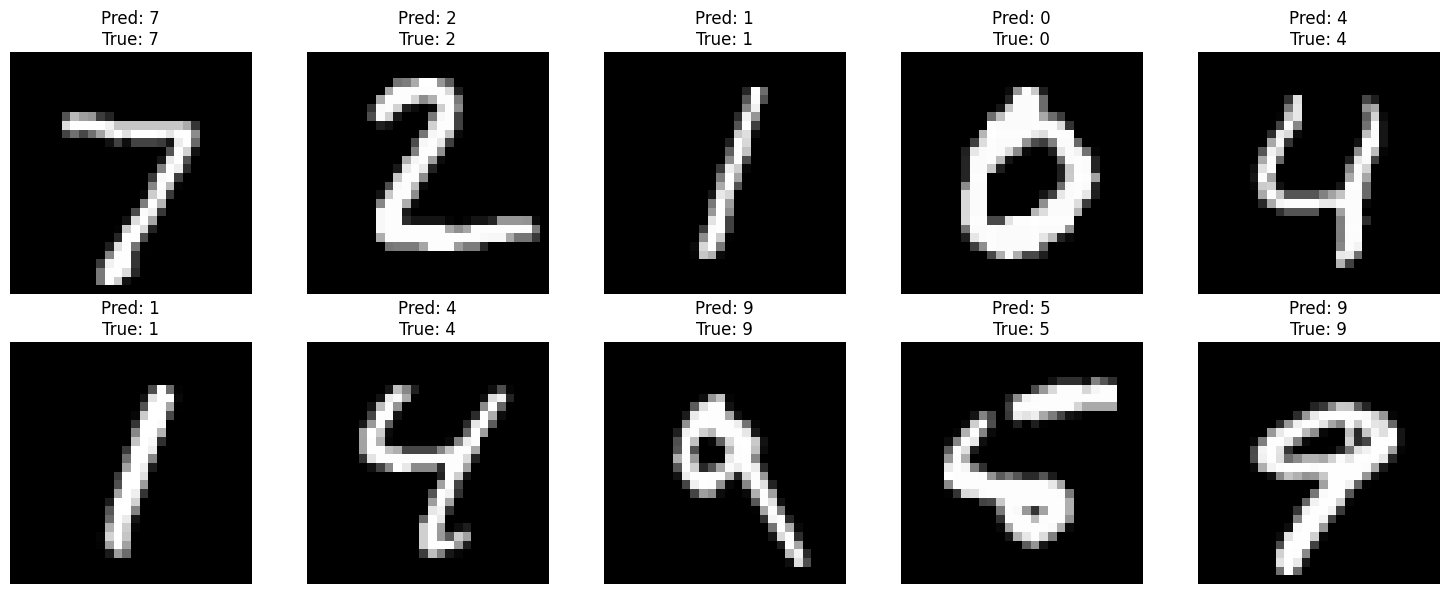

In [15]:
# Display some example predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    pred_label = np.argmax(y_pred[i])
    true_label = y_test_orig[i]
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [44]:
def preprocess_image(image_path):
    """
    Enhanced preprocessing for better handling of real-world images
    """
    try:
        # Read image
        image = Image.open(image_path).convert('L')
        
        # Convert to numpy array
        image = np.array(image)
        
        # Apply thresholding to make it more black and white
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        # Invert if needed (ensure digits are white on black background)
        if np.mean(image[0]) > 127:  # if background is white
            image = 255 - image
        
        # Find bounding box of digit
        coords = cv2.findNonZero(image)
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            image = image[y:y+h, x:x+w]
        
        # Pad to make it square
        height, width = image.shape
        size = max(height, width) + 10  # add padding
        square = np.zeros((size, size), dtype=np.uint8)
        x_offset = (size - width) // 2
        y_offset = (size - height) // 2
        square[y_offset:y_offset+height, x_offset:x_offset+width] = image
        
        # Resize to 28x28
        image = cv2.resize(square, (28, 28))
        
        # Normalize
        image = image.astype('float32') / 255.0
        
        return image.reshape(1, 28, 28, 1)
    
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        return None



In [45]:
def predict_digit(image_path, model):
    """
    Predict digit from an image file using the trained MNIST model.
    """
    try:
        # Preprocess image
        processed_image = preprocess_image(image_path)
        if processed_image is None:
            return None, None, None, None
        
        # Get prediction
        prediction = model.predict(processed_image, verbose=0)
        predicted_digit = np.argmax(prediction[0])
        confidence = float(prediction[0][predicted_digit])
        
        # Get original image for display
        original_image = plt.imread(image_path)
        
        return predicted_digit, confidence, processed_image[0], original_image
    
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None, None, None, None



In [46]:
def display_results(original_image, preprocessed_image, predicted_digit, confidence):
    """
    Display the original image, preprocessed image, and prediction results.
    """
    plt.figure(figsize=(12, 4))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Preprocessed Image and Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image.reshape(28, 28), cmap='gray')
    plt.title(f'Preprocessed Image\nPredicted Digit: {predicted_digit}\nConfidence: {confidence:.2%}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [47]:
def process_and_predict(image_path, model):
    """
    Process an image and show prediction results.
    """
    try:
        # Get prediction and images
        predicted_digit, confidence, preprocessed_image, original_image = predict_digit(image_path, model)
        
        if predicted_digit is not None:
            print(f"\nPrediction Results:")
            print(f"----------------")
            print(f"Predicted Digit: {predicted_digit}")
            print(f"Confidence: {confidence:.2%}")
            
            # Display images and prediction
            display_results(original_image, preprocessed_image, predicted_digit, confidence)
        else:
            print("Failed to process image and make prediction.")
            
    except Exception as e:
        print(f"Error: {str(e)}")



Prediction Results:
----------------
Predicted Digit: 5
Confidence: 100.00%


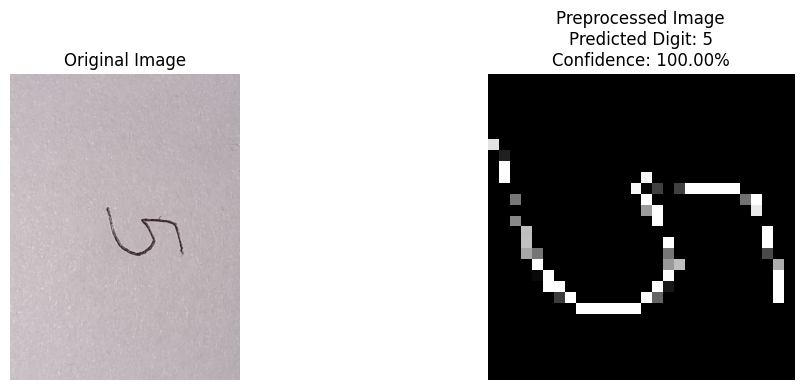

In [49]:
image_path = r"C:\Users\aksha\Downloads\WhatsApp Image 2024-10-28 at 16.38.40.jpeg"
process_and_predict(image_path, model)